# Hauptkomponentenanalyse
# (Principal Component Analysis, PCA)
# vs. 
# Denoising Variational Autoencoders

## _Intuition, Beispiele und  Formalismus_

jupyter nbconvert PCAvsDVAEde.ipynb --to slides --post serve

# Eine intuitive Perspektive ...

#### "... realistische, hochdimensionale Daten konzentrieren sich in der Nähe einer nichtlinearen, niedrigdimensionalen Mannigfaltigkeit ..." [Lei et al., 2018]

![](manifold.png)

# Eine intuitive Perspektive ...

#### Aber wie lernt man die Mannigfaltigkeit und die Wahrscheinlichkeitsverteilung darauf?
![](manifold-generic.png)

# PCA vs. DVAE an Hand von Beispielen

# PCA vs. DVAE an Hand von Beispielen

Der __MNIST (Modified National Institute of Standards and Technology) Datensatz__ von handgeschriebenen Zahlen besteht aus __60,000 Trainings- und 10,000 Test-Beispielen__. Dieser gehört zu einem größeren Datensatz, der von NIST zur Verfügung gestellt wird. Die Zahlen wurden hinsichtlich Ihrer Größe __normalisiert und in einem Bild fester Größe zentriert__. 

![](mnist.png)

# Vorstellung der Wettbewerber

# PCA 

* __Unüberwachtes__ Lernen
* __Lineare Transformation__
  
![](pca-intuition.png)

# PCA 

![](pca-intuition.png)
* __"Transformiere"__ eine Menge von Beobachtungen in ein __anderes Koordinatensystem__, in dem die Werte der ersten Koordinate (Komponente) die __größtmögliche Varianz__ aufweisen [Friedman et al., 2017]
* Die __resultierenden Koordinaten (Komponenten)__ sind __nicht__ mit den ursprünglichen Koordinaten __korreliert__    

# PCA 

* praktische Berechnung
    * __Eigenwertzerlegung der Kovarianz-Matrix__
    * __Singulärwertzerlegung__ der Beobachtungen
    ![](svd-graphic-simple.png)
* Wird zur __Dimensions-Reduzierung__ genutzt (Komprimierung)
* Die __Rekonstruktion der Beobachtungen__("decoding") aus den führenden __Hauptkomponenten__ hat den __niedrigsten quadratischen Fehler__

# Autoencoders

* unüberwachtes __neuronales Netz__
* __minimiert__ den Fehler zwischen Rekonstruktionen und Beobachtungen [Goodfellow et al., 2016]
* lernt die __Identitätsfunktion__
* wird mit Hilfe von __Fehlerrückführung (Backpropagation) trainiert__
* aufgetrennt um __Kodierung und Dekodierung__ zu erreichen

# Autoencoders

Das folgende Schaubild zeigt eine typische __Autoencoder Pipeline__ 

![](autoencoder-pipeline.png)

# PCA vs. Autoencoders

*  Ein __Autoencoder__ mit einer einzelnen __voll verbundenen (fully-connected) versteckten Ebene__, einer __linearen Aktivierungsfunktion__ und dem __quadratischen Fehler als Kostenfunktion__ ist __eng mit der PCA verwandt__ - seine __Gewichten__ spannen den __Untervektorraum der Hauptkomponenten__ auf [Plaut, 2018]


* Bei __Autoencodern__ sorgt die __diagonale Approximation beim Kodiervorgang__ zusammen mit der __inhärenten Stochastizität__ für lokale __Orthogonalität beim Dekodieren__

# PCA vs. Autoencoders

* Das Verhalten bei Autoencoders hinsichtlich __Rekonstruktion und Orthogonalität__ ähnelt stark der __Einbettung__, welche bei der __PCA__ gewählt wird [Rolinek et al, 2019]


* Der Unterschied besteht darin, dass bei der __Ausgabe von Autoencodern__, im Gegensatz zur PCA, die __Koordinaten korreliert__ und __nicht der Größe (im Hinblick auf die Varianz) nach absteigend sortiert sind__

# PCA vs. Autoencoders 
# Implementierung

In [1]:
# import all necessary libs
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
# we use Keras to implement, layer-by-layer the DVAE and PCA
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape
from sklearn.decomposition import PCA
import os
%matplotlib inline
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


## Grundlegende Mathematik der PCA

### Lineare Transformation

* Es sei $\{y_i\}^N_{i=1}$ eine Menge von $N$ Beobachtungs-Vektoren der Dimension $n$ mit $n\leq N$.

* Eine __lineare Transformation__ eines __endlich-dimensionalen__ Vektors kann als __Matrix Multiplikation__ ausgedrückt werden: 

$$ \begin{align} x_i = W y_i \end{align} $$  
  
mit $y_i \in R^{n}, x_i \in R^{m}$ und $W \in R^{nxm}$. 

## Grundlegende Mathematik der PCA

### Lineare Transformation

* Das $j-te$ Element in $x_i$ ist das __Innere Produkt__ von $y_i$ und der $j-ten$ Spalte der Matrix $W$, welche wir durch $w_j$ bezeichen. Es sei $Y \in R^{nxN}$ die Matrix, welche wir durch horizontale Aneinanderreihung der Vektoren $\{y_i\}^N_{i=1}$ erhalten, 

$$ Y = \begin{bmatrix} | ... | \\ y_1 ... y_N \\ | ... | \end{bmatrix} $$

* Aus der __linearen Transformation__ folgt:

$$ X = W^TY,  X_0 = W^TY_0, $$

wobei $Y_0$ die __Matrix der zentrierten Elemente__ (d.h. wir subtrahieren den Mittelwert von jeder Beobachtung) bezeichnet.

### Maximale Varianzkomponenten, Kovarianz und Dekorrelation

* Wenn $W^T$ Transformation darstellt, welche die __Hauptkomponentenanalyse__ bezeichnet, so bezeichnen wir $W = P$. Jede Spalte der Matrix $P$, welche durch  $\{p_j\}^n_{j=1}$ bezeichnen, ist ein __Ladungs-Vektor__, wohingegen jeder transformierte Vektor $\{x_i\}^N_{i=1}$ eine __Hauptkomponente__ ist.

### Dimensionsreduzierung, Komprimierung, Skalierung

PCA wird zur __Dimensions-Reduktion__ verwendet, da sie durch die durch eine lineare Transformation die __Anzahl der Variablen reduziert__. Dies wird erreicht, indem man die ersten $m$ Hauptkomponenten $(m < n)$ erhält und die folgende Gleichung anwendet:

$$ X_m = P_m^TY$$

Da nur die ersten $m$ Hauptkomponenten erhalten werden, __verliert__ PCA __information__ (d.h. __verlustreiche Komprimierung__). Der __Verlust__ wird jedoch durch die __Maximierung der Komponenten-Varianzen minimiert__.

### Dimensionsreduzierung, Komprimierung, Skalierung

Zur Berechung der $m$ größten Eigenwerte von $Y_0Y_0^T$ können viele verschiedene __iterative Algorithmen__ eingesetzt werden 
* QR Algorithmen
* Jacobi Algorithmus
* Power methode
* Singulärwert-Zerlegung (Singular Value Decomposition, SVD)

Für __sehr große Datenmengen__ eignen sich diese Algorithmen __nicht__!

### Minimaler quadratischer Gesamtrekonstruktionsfehler

Die Transformations-Matrix $P_m$ kann ebenfalls durch Lösung der folgenden Gleichung berechnet werden:

$$ \min_{W \in R^{nxm}} \| Y_0 - WW^TY_0 \|_F^2, W^TW = I_{mxm}$$

wobei $F$ die Frobenius-Norm bezeichnet. 

Daraus folgt, dass $P_m$ __jeden zentrierten Vektor__ der Länge $n$ in einen Vektor der Länge $m$ mit ($ m < n$) derart __komprimiert__, dass die __Summe des quadratischen Rekonstruktions-Fehlers minimiert wird__. 

In [2]:
# analytical PCA of the training set
def analytical_pca(y):
    # variance to explain
    pca = PCA(0.7)
    # apply PCA
    pca.fit(y)
    # extract the components 
    loadings = pca.components_
    # apply the transformation
    components = pca.transform(y)
    # reconstruct from components for visualization
    filtered = pca.inverse_transform(components)
    return filtered

In [3]:
# training params for PCA vs. DVAE
num_train = 50000
n_images = 6
batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0
noise_factor = 0.5

In [150]:
# get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# prepare data for PCA
# training
x_test_pca = x_test
shape_x_test = x_test_pca.shape                                                               
pcaInputTest = np.reshape(x_test,[shape_x_test[0],shape_x_test[1]*shape_x_test[2]]).astype('float32')/255

# prepare data for DVAE                                      
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

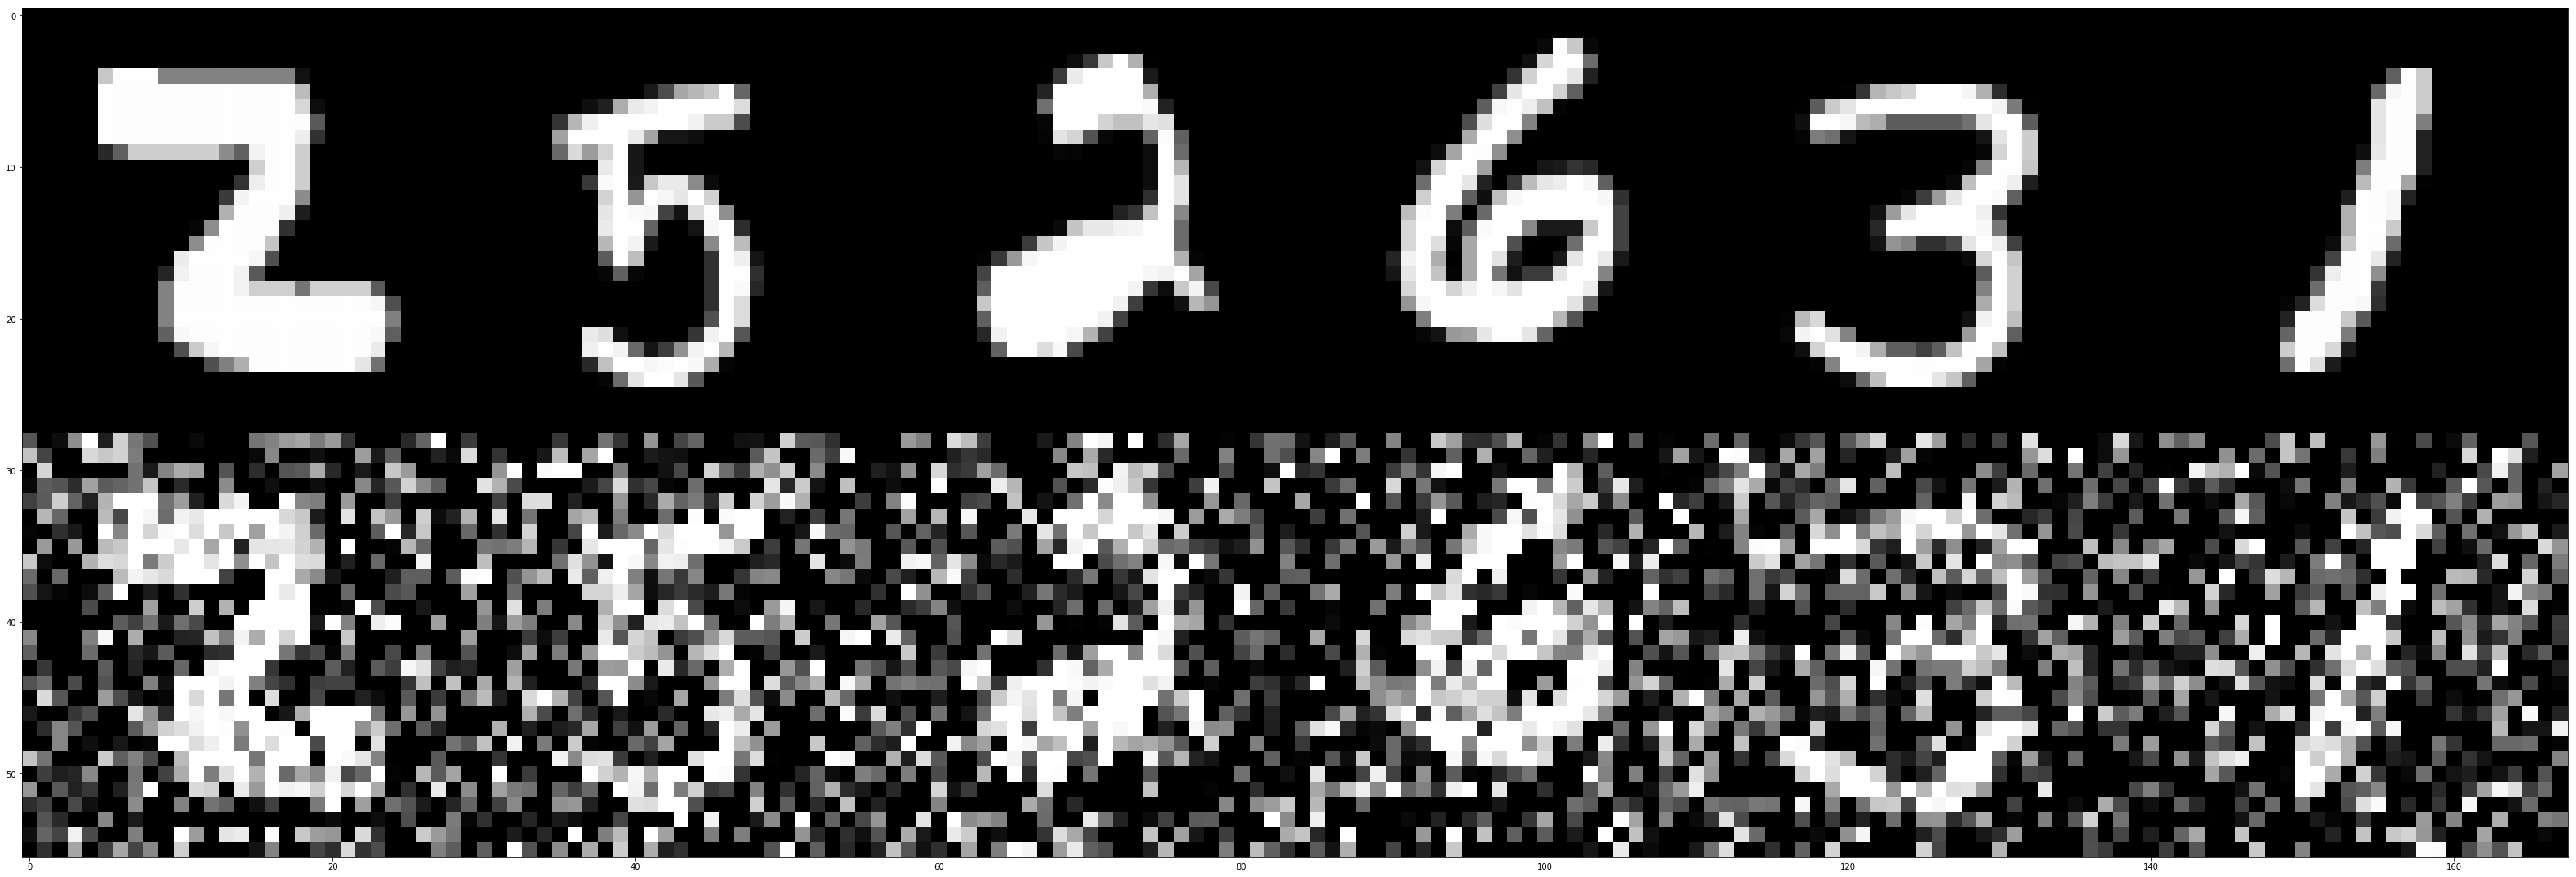

In [140]:
# display the images (28x28 px)
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n_images))
showidx=np.random.randint(0,num_train,n_images)

# display input, noisy input
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])

plt.figure(figsize=(28*2, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Grundlegende Mathematik der Autoencoder

Für jeden Eingangsvektor $x$ der Dimension $d$ des kompletten Datensaztes der Länge $n$ generiert das neuronale Netz eine Rekonstruktion $x'$ durch:

* __Kodierung der Eingangsdaten__ (d.h. verwende die lineare / nicht-lineare Transformation $g_\phi(.)$)
* dies liefert eine __verborgende, komprimierte Kodierung__ in der dünnsten Netzwerk-Ebene, $z$
* __Dekodierung der komprimierten Eingangsdaten__ durch Anwendung der linearen / nicht-linearen Transformation $f_\theta(.)$

![](autoencoder.png)

## Grundlegende Mathematik der Autoencoder

Die __Parameter $(\theta, \phi)$ werden im Verlauf des Training derart optimiert__, dass ein den Eingangsdaten möglichst ähnliches Ergebnis , $x \approx f_\theta(g_\phi(x))$, produziert wird. In anderen Worten: __die Indentitäts-Funktion wird erlernt__.

__Metriken um die Ähnlichkeit zwischen Eingangsdaten und Rekonstruktion__: __Cross-Entropy (bei sigmoid Aktivierungsfuntionen)__, __mittlere quadratische Fehler (MSE)__ etc.:

$$ \frac{1}{n} \sum_{i=1}^{n}(x^{i} - f_\theta(g_\phi(x^{i}))^2$$

![](autoencoder.png)

# Denoising Variational Autoencoders (DVAE)

Das Funktionsprinzip __unterscheidet sich__ vom grundlegenden Autoencoder dahingehend, dass ein gewisses Maß an __Störrauschen__  (einer __gewissen Wahrscheinlichkeitsverteilung__ folgend) den __Eingangsdaten hinzugefügt wird__ und dass die __verborgenen Ebenen__ dieses Rauschen ausgleichen muss um die Eingangsdaten zu __rekonstruieren__ [Im, Bengio et al., 2017, Kingma et al., 2017].

![](denoising-variational-autoencoder.png)

# Denoising Variational Autoencoders (DVAE)

Für jeden gestörten Eingangsvektor $\tilde x$ eines originalen Vektors $x$ der Dimension $d$, generiert das neuronale Netz eine Rekonstruktion $x'$ durch:
* __Kodierung der Eingangsdaten__, welche die Abbildung als Wahrscheinlichkeit der Schätzung von $z$ unter Verwendung der Eingangsdaten darstellt
* dies liefert eine __verborgende, komprimierte Kodierung in der dünnsten Netzwerk-Ebene__ $z$, welche der Verteilung $q_\phi(z|x)$ folgt
* __Dekodierung der komprimierten Eingangsdaten__ an der Ausgangsebene unter Einhaltung des __Beobachtungs-Modells__ $p_\theta(x|z)$

![](denoising-variational-autoencoder.png)

In [6]:
# Implement the DVAE
# encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [7]:
# Implement the DVAE
# reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [8]:
# Implement the DVAE
# decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

## Grundlegende Mathematik der DVAE

Die __Verlustfunktion zur Wiederherstellung__ der ursprünglichen Eingangsdaten (__nicht die gestörten__), $\tilde{x}^{i} = M(\tilde{x}^{i} | x^{i}) $.

DVAE __Verlustfunktion__ beinhaltet die Erstellung von Beispielen aus $z \backsim q_\phi(z|x)$. Dies ist ein __stochastischer Prozess__ und eignet sich daher __nicht zur Fehlerrückführung__.

## Grundlegende Mathematik der DVAE

Die __geschätzte Posteriori-Verteilung $q_\phi(z|x)$__ approximiert die tatsächliche Verteilung $p_\theta(z|x)$. Wir können die __Kullback-Leibler Abweichung__ benutzen um die __Differenz der beiden Verteilungen__ zu quantifizieren. Die KL Abweichung $D_{KL}(X∥Y)$ misst den __Informationsverlust__ wenn die Verteilung Y verwendet wird um X darzustellen.


## Grundlegende Mathematik der DVAE

Bei __abweichenden Bayesischen Methoden__ wird die Verlustfunktion auch die abweichende untere Schranke oder auch __evidence lower bound (ELBO)__ genannt. 

Durch __Minimierung des Verlusts__, __maximieren__ wir daher die __untere Schranke der Wahrscheinlichkeit__ zur Generierung echter Daten-Beispiele.

In [11]:
# Implement the DVAE
# instantiate model
dvae = Model(x_noise, x_out)
dvae.summary()

# Compute loss
def DVAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    dvae_loss = K.mean(xent_loss + kl_loss)
    return dvae_loss

# compile the model
dvae.compile(optimizer='adam', loss=DVAE_loss)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
# Train the DVAE
dvae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 447s 7ms/step - loss: 241.2101 - val_loss: 175.7817
Epoch 2/10
60000/60000 [==============================] - 443s 7ms/step - loss: 152.2238 - val_loss: 137.2563
Epoch 3/10
60000/60000 [==============================] - 443s 7ms/step - loss: 133.9951 - val_loss: 130.0983
Epoch 4/10
60000/60000 [==============================] - 444s 7ms/step - loss: 129.5809 - val_loss: 127.0901
Epoch 5/10
60000/60000 [==============================] - 446s 7ms/step - loss: 127.2348 - val_loss: 125.8064
Epoch 6/10
60000/60000 [==============================] - 446s 7ms/step - loss: 125.5931 - val_loss: 126.7961
Epoch 7/10
60000/60000 [==============================] - 444s 7ms/step - loss: 124.6809 - val_loss: 123.5049
Epoch 8/10
60000/60000 [==============================] - 444s 7ms/step - loss: 123.6281 - val_loss: 123.3322
Epoch 9/10
60000/60000 [==============================] - 445s 7ms/ste

In [142]:
# Comparison PCA vs. DVAE
# testing the DVAE
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=dvae.predict(x_test[showidx])

# prepare data for testing PCA
pcaOutput = analytical_pca(pcaInputTest)

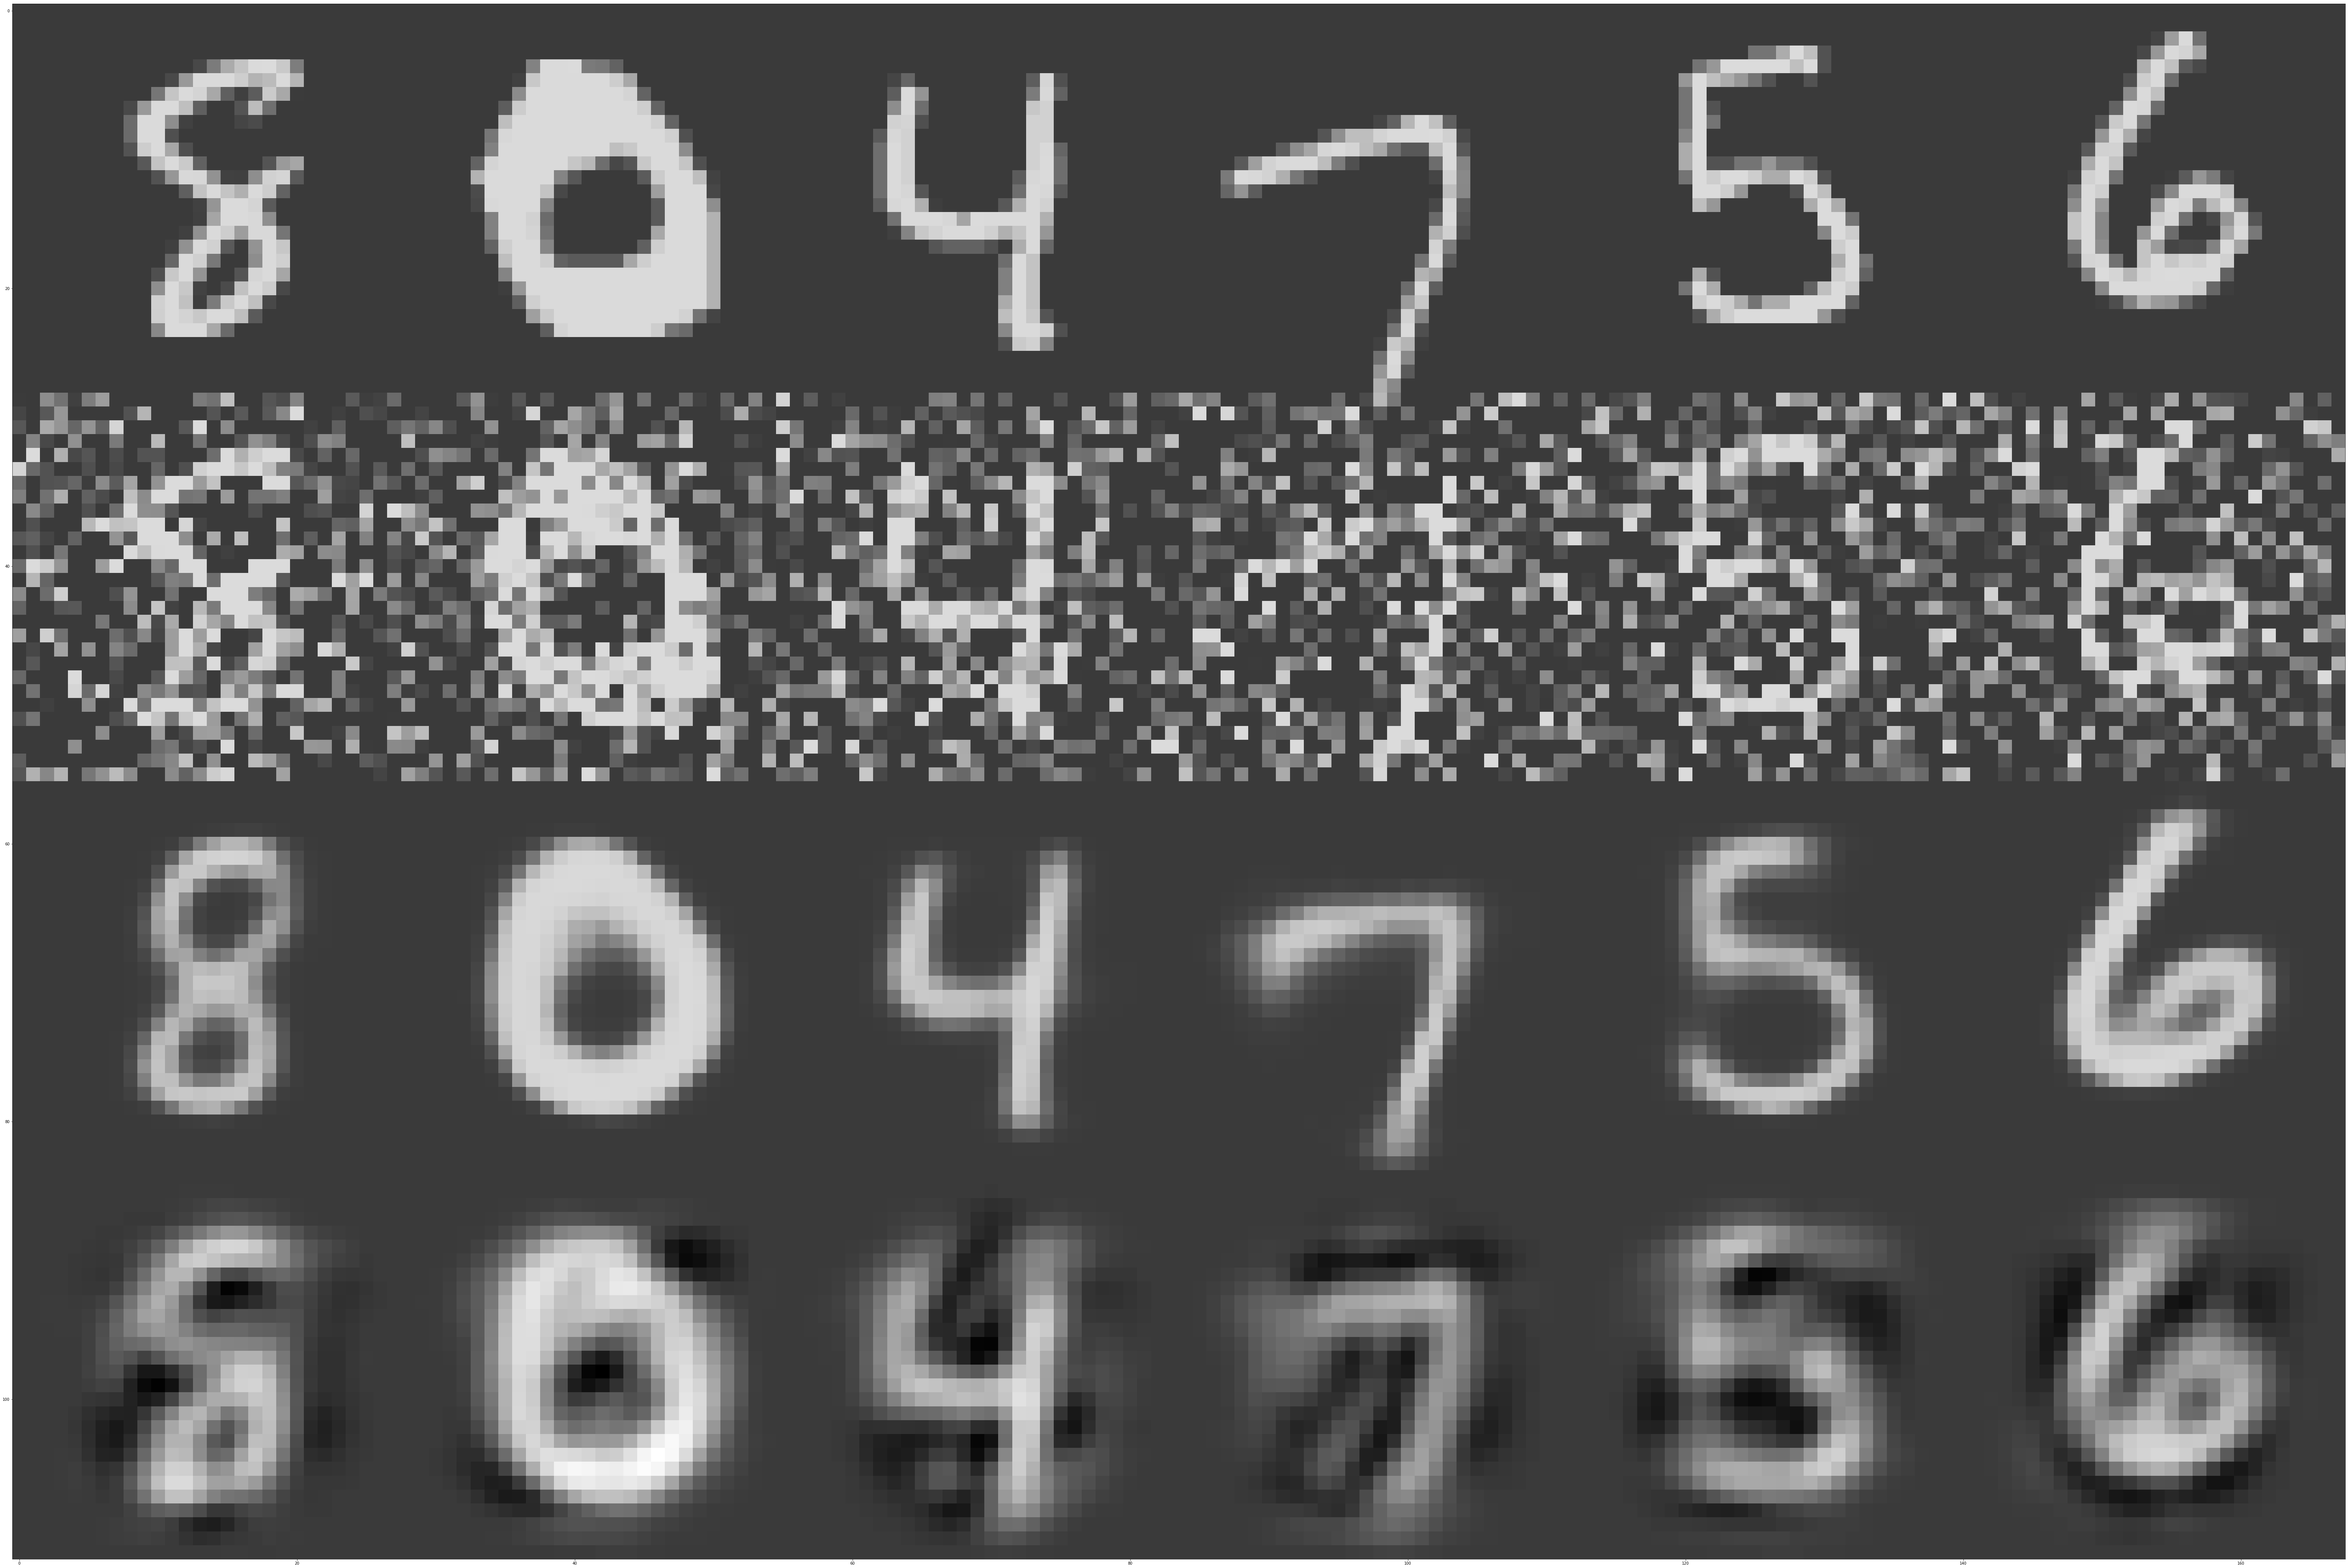

In [143]:
# Display results
digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))

for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28]) # input data
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28]) # noisy input data 
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28]) # DVAE output
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = np.reshape(pcaOutput[idx], [28, 28]) # PCA output

plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('inference_output.png')
plt.show()

In [88]:
%%HTML 
<style>
td {
  font-size: 15px
}
</style>

# Vergleich von PCA und DVAE

### Inference

![](inference_output.png)

# Vergleich von PCA und DVAE

### Kostenfunktion

![](loss.png)

# Vergleich von PCA und DVAE

### Lernen der Mannigfaltigkeit

|__PCA__|__DVAE__|
|:-----|:---|
| Kodierung/Dekodierung, keine Robustheit gegen Rauschen | nicht-linear, probabilistische Kodierung/Dekodierung mit Robustheit gegen Rauschen und nicht-linearen Aktivierungsfunktionen|
| unkorrelierte Koordinaten | korrelierte Ausgansdaten an der dünnsten Netzwerkebene |
| Koordinaten sind in absteigener Reihenfolge der Varianz geordnet | Koordinaten sind ungeordnet |
| die Spalten der Transformations-Matrix sind orthonormal | die Spalten der Transformations-Matrix sind nicht notwendigerweise orthonormal |
| Robustheit gegenüber moderatem Rauschen mit bekannten Verteilungen | Robustheit gegen eine Vielzahl verschiedener Arten und Größenordnungen an injeziertem Rauschen (masking noise, Gaussian noise, salt-and-pepper noise), da das Entrauschen entscheidung für die Generalisierung ist |
| einfacher Algorithmus (ohne Regularisierung), geringe Robustheit | die Punkte in niedrig-dimensionalen Mannifaltigkeiten sind robust gegen Rauschen im hoch-dimensionalen Beobachtungs-Raum |

# Vergleich zwischen PCA und DVAE

### Training 

|__PCA__|__DVAE__|
|:-----|:---|
| Abbildung der Eingangsdaten auf einen festen Vektor | Abbildung der Eingangsdaten auf eine Wahrscheinlichkeitsverteilung |
| iterative Methoden: QR Zerlegung, Jacobi Algorithmus, Singulärwertzerlegung | Fehlerrückführung (Backpropagation)  |
| aufgrund der Kovarianz-Berechnung ineffizient bei großen Datenmengen | effizient bei großen Datenmengen aufgrund der starken Fähigkeit des Erlernens der Mannigfaltigkeit |
| basiert auf der Korrelations-/Kovarianz-Matrix, welche - zumindest in der Theorie - sehr empfindlich gegenüber Ausreißern sein kann | kann Beispiele direkt aus dem Eingangsraum generieren und daher die Eigenschfaten des Eingangsrauschens beschreiben ("reparametrization trick") |

# Lieraturverzeichnis

[Goodfellow et al., 2016] Ian Goodfellow, Yoshua Bengio and Aaron Courville, Deep Learning, MIT Press, 2016.

[Friedman et al., 2017] Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie, The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Springer, 2017.

[Plaut, 2018] Plaut, E., 2018. From principal subspaces to principal components with linear autoencoders. arXiv preprint arXiv:1804.10253.

[Im, Bengio et al., 2017] Im, D.I.J., Ahn, S., Memisevic, R. and Bengio, Y., 2017, February. Denoising criterion for variational auto-encoding framework. In Thirty-First AAAI Conference on Artificial Intelligence.

[Rolinek et al, 2019] Rolinek, M., Zietlow, D. and Martius, G., 2019. Variational Autoencoders Pursue PCA Directions (by Accident). In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 12406-12415).

[Lei et al., 2018] Lei, N., Luo, Z., Yau, S.T. and Gu, D.X., 2018. Geometric understanding of deep learning. arXiv preprint arXiv:1805.10451.

[Kingma et al., 2013] Kingma, D.P. and Welling, M., 2013. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.

### Maximale Varianzkomponenten, Kovarianz und Dekorrelation

* Der erste Ladungs-Vektor ist derjenige Einheitsvektor mit dem das innere Produkt der Beobachtungs-Vektoren die __größte Varianz__ aufweisen:

$$ \max w_1^T Y_0Y_0^Tw_1, w_1^Tw_1 = 1$$

* Die Lösung der vorherigen leichung ist der erste Eigenvektor der __Kovarianz-Matrix__ $Y_0Y_0^T$, welcher zum größten Eigenwert gehört.

* Die Matrix $P$ kann durch __Diagonalisierung der Kovarianz-Matrix__ berechnet werden:

$$ Y_0Y_0^T = P \Lambda P^{-1} = P \Lambda P^T $$

$\Lambda = Y_0Y_0^T $ ist eine Diagonal-Matrix, deren Diagonal-Elemente $\{\lambda_i\}^N_{i=1}$ der Größe nach absteigend sortiert sind. $ Y = PX $ liefert die inverse Tranformation. Da die Kovarianz-Matrix von $X$ diagonal ist, ist die PCA eine __dekorrelierende Transformation__.

### Singulärwert-Zerlegung 
### (Singular Value Decomposition, SVD)

Ein Vektor $v$ der Dimension $N$ ist ein __Eigenvektor__ einer quadratischen N × N Matrix $A$, wenn diese die folgende __lineare Gleichung__ erfüllt

$$Av =\lambda v$$

wobei $λ$ ein skalarer Wert ist, welcher als der __zum Eigenvektor v gehörende Eigenwert__ bezeichnet wird.

### Singulärwert-Zerlegung 
### (Singular Value Decomposition, SVD)

Die Matrix $Y_0 \in R^{nxN}$ kann __faktorisert__ werden als $Y_0 = U \Sigma V^T$, wobei $U \in R^{nxn}$ und $V \in R^{NxN}$ __orthogonale Matrizen__ sind und $\Sigma \in R^{nxN}$ abgesehen von der Diagonalwerten (den sogenannten __Singulär-Werten__) nur aus Nullen besteht.

Die Singulärwertzerlegung von $Y_0$ ist äquivalent zur __Eigenwertzerlegung__ von $Y_0T_0^T$. 

![](svd-graphic.png)